# Group-Level Epoch-Based Decoding Accuracy Aggregation Script

This script computes trial-level decoding accuracies for a P300 paradigm across a range of epoch counts. It uses cross-validation (with 4 folds) and evaluates the effect of increasing the number of epochs (or “epoch bins”) on trial-level performance. The key outputs are the group-level mean accuracies and their standard errors, aggregated by each epoch bin. Finally, the results are saved to an NPZ file.

---

## Workflow Overview

1. **Initialize Data Structures:**
   - `results_decoding`: A dictionary to store per-subject, per-fold accuracies along with aggregated group-level mean and standard error (SE) values.
   - `group_accuracies_per_epoch`: A helper dictionary used to gather accuracy values across subjects for each epoch count.

2. **Define Epoch Bins:**
   - `epoch_bins` is created using `np.linspace(5, 80, 16, dtype=int)`, generating 16 bins (from 5 to 80 epochs) which represent the number of epochs used for trial-level inference.

3. **Processing Each Subject:**

 **Note:** This script is not optimized for files that contain NaNs (which occur in _p300_features_.npz) because NaNs in cases of insufficient epochs can cause issues during bin aggregation. If a subject has too few epochs to be integrated, it will be flagged; therefore, only the “noreject” files (without NaNs) should be used.
     -
   - For each subject (iterating over a list of subjects), the script:
     - Loads the pre-saved feature file (NPZ) that contains:
       - `X`: EEG data (trials × channels × samples).
       - `y`: Labels indicating the cued side per trial.
       - `z`: Target information (trials × epochs × sides).
     - Splits the trials into 4 folds for cross-validation.
     - For each fold:
       - Separates the training and testing sets.
       - Reshapes the training data into epochs and extracts corresponding labels for LDA training. (A balancing function is optionally called to balance the classes.)
       - Similarly, reshapes the testing data for evaluation.
       - **Model Training:** An LDA classifier (with Ledoit-Wolf covariance estimator) is trained on the training epochs.
       - **Evaluation:** For every testing trial, the script computes the decision function scores from LDA over all epochs. Then, for each defined epoch bin (i.e. using only the first *n* epochs), it:
         - Computes correlations between the LDA scores and the left and right target values.
         - Assigns a trial-level decision based on which correlation is stronger.
         - Records a correctness indicator (1 if the decision matches the cued side; 0 otherwise).
       - The fold's trial accuracy is computed as the average of the correctness indicators for each epoch bin.
     - For each subject, the fold accuracies are averaged to produce subject-level accuracy per epoch bin.

4. **Group-Level Aggregation:**
   - The script collects subject-level accuracies for each epoch bin into `group_accuracies_per_epoch`.
   - For each epoch bin, the group-level mean accuracy and standard error (SE) are computed and stored in the `results_decoding` dictionary under the keys `"mean_accuracies"` and `"se_accuracies"`.

5. **Saving the Results:**
   - The epoch bins, group mean accuracies, and SE values are converted to NumPy arrays.
   - These arrays are saved in an NPZ file (e.g., `"covert_lda_p300_decC_results.npz"`)

---


In [1]:
import os
from os.path import join
import numpy as np
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))

analysis_dir = join(data_dir, "analysis")
p300_dir = join(analysis_dir, "p300")
decoding_results_dir = join(p300_dir, "decoding_results") 
plots_dir = join(p300_dir, "plots")
features_dir = join(plots_dir, "features")

subjects = ["VPpdia","VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig","VPpdih", "VPpdii", "VPpdij",
            "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
            "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix","VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"]



In [2]:
def balance_classes(X, y, ratio_0_to_1=1.0):
    
    """
    Sub-select X and y based on a specified ratio of 0s to 1s, keeping the original order.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n_samples, n_features).
    y (numpy.ndarray): Label vector of shape (n_samples,).
    ratio_0_to_1 (float): The desired ratio of 0s to 1s in the balanced dataset.

    Returns:
    X_balanced, y_balanced: Sub-selected feature matrix and label vector.
    """
    # Step 1: Identify indices of 0s and 1s
    indices_0 = np.where(y == 0)[0]
    indices_1 = np.where(y == 1)[0]
    
    # Step 2: Calculate the number of samples to select for each class
    num_1s = len(indices_1)
    num_0s = min(len(indices_0), int(num_1s * ratio_0_to_1))
    
    # Step 3: Randomly sample the desired number of 0s and 1s
    selected_indices_0 = np.random.choice(indices_0, num_0s, replace=False)
    selected_indices_1 = np.random.choice(indices_1, num_1s, replace=False)
    
    # Step 4: Combine selected indices and sort to preserve original order
    balanced_indices = np.sort(np.concatenate([selected_indices_0, selected_indices_1]))
    
    # Step 5: Sub-select X and y based on the balanced indices
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    return X_balanced, y_balanced

In [3]:
def filter_valid_epochs(X, y, z=None, return_mask=False):
    """
    Filters out epochs where either the features in X or the labels in y contain NaN values.
    Optionally, if a z array is provided, it is filtered similarly.
    
    Parameters:
        X (np.ndarray): A 2D numpy array with shape (n_epochs, n_features).
        y (np.ndarray): A 1D numpy array with shape (n_epochs,).
        z (np.ndarray, optional): An array that will be filtered using the same mask.
        return_mask (bool, optional): If True, the boolean mask used for filtering is returned.
    
    Returns:
        filtered_X (np.ndarray): X with only rows that have no NaN values.
        filtered_y (np.ndarray): y with only entries corresponding to valid epochs.
        filtered_z (np.ndarray or None): Filtered z array (if provided) or None.
        mask (np.ndarray, optional): The boolean mask of valid epochs; only returned if return_mask=True.
    """
    # Create a mask for valid labels and features
    valid_label_mask = ~np.isnan(y)
    valid_feature_mask = ~np.isnan(X).any(axis=1)
    combined_mask = valid_label_mask & valid_feature_mask

    # Apply the mask to X and y
    filtered_X = X[combined_mask]
    filtered_y = y[combined_mask]
    
    if z is not None:
        filtered_z = z[combined_mask]
    else:
        filtered_z = None

    if return_mask:
        return filtered_X, filtered_y, filtered_z, combined_mask
    else:
        return filtered_X, filtered_y, filtered_z

## Decoding curve 

In [4]:

results_decoding = {
    "subjects": {},       # Holds per-subject, per-fold accuracies
    "mean_accuracies": {},# Holds aggregated mean accuracies across all subjects/folds
    "se_accuracies": {}   # Holds aggregated standard-error values across all subjects/folds
}

group_accuracies_per_epoch = {}
# Epoch bins
epoch_bins = np.linspace(5, 80, 16, dtype=int)
task = 'covert'
# Iterate over subjects
for subject in subjects:
    file_dir = os.path.join(derivatives_dir, 'features', "p300", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_p300_features_noreject.npz")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

     # Load the data from the NPZ file
    npz_data = np.load(file_path)
    # Extract data
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels indicating cued side: trials
    z = npz_data['z']  # Left and right targets: trials x epochs x sides


    # Instantiate Cross-validation
    n_folds = 4
    n_trials = int(X.shape[0] / n_folds)
    folds = np.repeat(np.arange(n_folds), n_trials)

    # Initialize results structure for this subject
    results_decoding["subjects"][subject] = {fold: [] for fold in range(n_folds)}

    for i_fold in range(n_folds):
        # Split into train and test sets
        X_trn_trials, y_trn_trials, z_trn_trials = X[folds != i_fold], y[folds != i_fold], z[folds != i_fold]
        X_tst_trials, y_tst_trials, z_tst_trials = X[folds == i_fold], y[folds == i_fold], z[folds == i_fold]
        
        # Reshape and balance training data 
        # Build labels for LDA
        X_trn_epochs = X_trn_trials.reshape(-1, X_trn_trials.shape[2] * X_trn_trials.shape[3])
        trial_indices_trn = np.arange(len(y_trn_trials))
        y_trn_epochs = z[trial_indices_trn, :, y_trn_trials].reshape(-1)
        # Balancing commented out
        X_trn_epochs, y_trn_epochs = balance_classes(X_trn_epochs, y_trn_epochs, ratio_0_to_1=1)
        
        # Reshape testing data
        # Build labels for LDA
        X_tst_epochs = X_tst_trials.reshape(-1, X_tst_trials.shape[2] * X_tst_trials.shape[3])
        trial_indices_tst = np.arange(len(y_tst_trials))
        y_tst_epochs = z[trial_indices_tst, :, y_tst_trials].reshape(-1)
        
        # Train LDA
        lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())
        lda.fit(X_trn_epochs, y_trn_epochs)
        
        # Evaluate model on test data
        fold_results = {epoch_count: [] for epoch_count in epoch_bins}

        for t_idx in range(len(y_tst_trials)):
            left_targets = z_tst_trials[t_idx, :, 0]
            right_targets = z_tst_trials[t_idx, :, 1]
            cued_side = y_tst_trials[t_idx]
            cued_targets = z_tst_trials[t_idx, :, cued_side]
            num_epochs = X_tst_trials.shape[1]
            epoch_scores = lda.decision_function(X_tst_trials[t_idx].reshape(num_epochs, -1))
            
            # Evaluate accuracy across each epoch counts
            # How many are needed for accurate trail-level inference
            for epoch_count in epoch_bins:
                cued_targets_subset = cued_targets[:epoch_count]
                epoch_scores_subset = epoch_scores[:epoch_count]
                left_targets_subset = left_targets[:epoch_count]
                right_targets_subset = right_targets[:epoch_count]

                # Eval correlation to both sides
                corr_left, _ = pearsonr(epoch_scores_subset, left_targets_subset)
                corr_right, _ = pearsonr(epoch_scores_subset, right_targets_subset)

                # Decide Trial label based on strongest corr
                decision = 0 if corr_left > corr_right else 1
                correct = int(decision == cued_side)
                fold_results[epoch_count].append(correct) # Exlude

        # Append average accuracy of fold results to subject
        results_decoding["subjects"][subject][i_fold] = {key: sum(values) / len(values) for key, values in fold_results.items()}

# Aggregate results across subjects
    subject_means = {}
    for epoch_count in epoch_bins:
        fold_values = []
        for i_fold in range(n_folds):
            fold_values.append(results_decoding["subjects"][subject][i_fold][epoch_count])
        subject_means[epoch_count] = np.mean(fold_values)
    
# Accumulate into group structure
    for epoch_count, subj_mean_acc in subject_means.items():
        if epoch_count not in group_accuracies_per_epoch:
            group_accuracies_per_epoch[epoch_count] = []
        group_accuracies_per_epoch[epoch_count].append(subj_mean_acc)

# Final group-level mean & SE
for epoch_count in epoch_bins:
    subject_accs = group_accuracies_per_epoch[epoch_count]
    group_mean = np.mean(subject_accs)
    group_std  = np.std(subject_accs) 
    group_se   = group_std / np.sqrt(len(subject_accs))
    results_decoding["mean_accuracies"][epoch_count] = group_mean
    results_decoding["se_accuracies"][epoch_count]   = group_se


# results_decoding STRUCTURE
'''
 ├─ "subjects"
 │   ├─ subject_01
 │   │   ├─ 0  (fold index 0)
 │   │   │   ├─ epoch_count_1: accuracy_value
 │   │   │   ├─ epoch_count_2: accuracy_value
 │   │   │   └─ ...
 │   │   ├─ 1  (fold index 1)
 │   │   ├─ 2
 │   │   └─ 3
 │   ├─ subject_02
 │   └─ ...
 ├─ "mean_accuracies"
 │   ├─ epoch_count_1: mean_accuracy
 │   ├─ epoch_count_2: mean_accuracy
 │   └─ ...
 └─ "se_accuracies"
     ├─ epoch_count_1: se_accuracy
     ├─ epoch_count_2: se_accuracy
     └─ ...

'''

# !! Save Files
epoch_bins = sorted(results_decoding["mean_accuracies"].keys())

# 2) Build arrays from the dict
mean_acc_array = np.array([results_decoding["mean_accuracies"][epoch] for epoch in epoch_bins])
se_acc_array   = np.array([results_decoding["se_accuracies"][epoch] for epoch in epoch_bins])

# 3) Optionally convert epoch_bins to a NumPy array as well (for reference)
epoch_bins_array = np.array(epoch_bins)

# 4) Save the arrays into an NPZ file:
save_path = join(decoding_results_dir, f"{task}_lda_p300_decC_results.npz")
np.savez(
    save_path,
    epoch_bins=epoch_bins_array,
    mean_accuracies=mean_acc_array,
    se_accuracies=se_acc_array
)
print(f"results saved to {save_path}")

C:\Users\Radovan\AppData\Local\Temp\ipykernel_35284\3690570749.py:79: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_right, _ = pearsonr(epoch_scores_subset, right_targets_subset)
C:\Users\Radovan\AppData\Local\Temp\ipykernel_35284\3690570749.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_left, _ = pearsonr(epoch_scores_subset, left_targets_subset)
C:\Users\Radovan\AppData\Local\Temp\ipykernel_35284\3690570749.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_left, _ = pearsonr(epoch_scores_subset, left_targets_subset)
C:\Users\Radovan\AppData\Local\Temp\ipykernel_35284\3690570749.py:79: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_right, _ = pearsonr(epoch_scores_subset, right_targets_subset)
C:\Users\Radovan\AppData\Local\Temp\ipykernel_35284\3690570749.py:79

results saved to C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root\data\analysis\p300\decoding_results\covert_lda_p300_decC_results.npz


## Plot subject resolved Decoding Curve

Plot saved to C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root\data\analysis\p300\decoding_results\covert_lda_p300_decC_results.npz


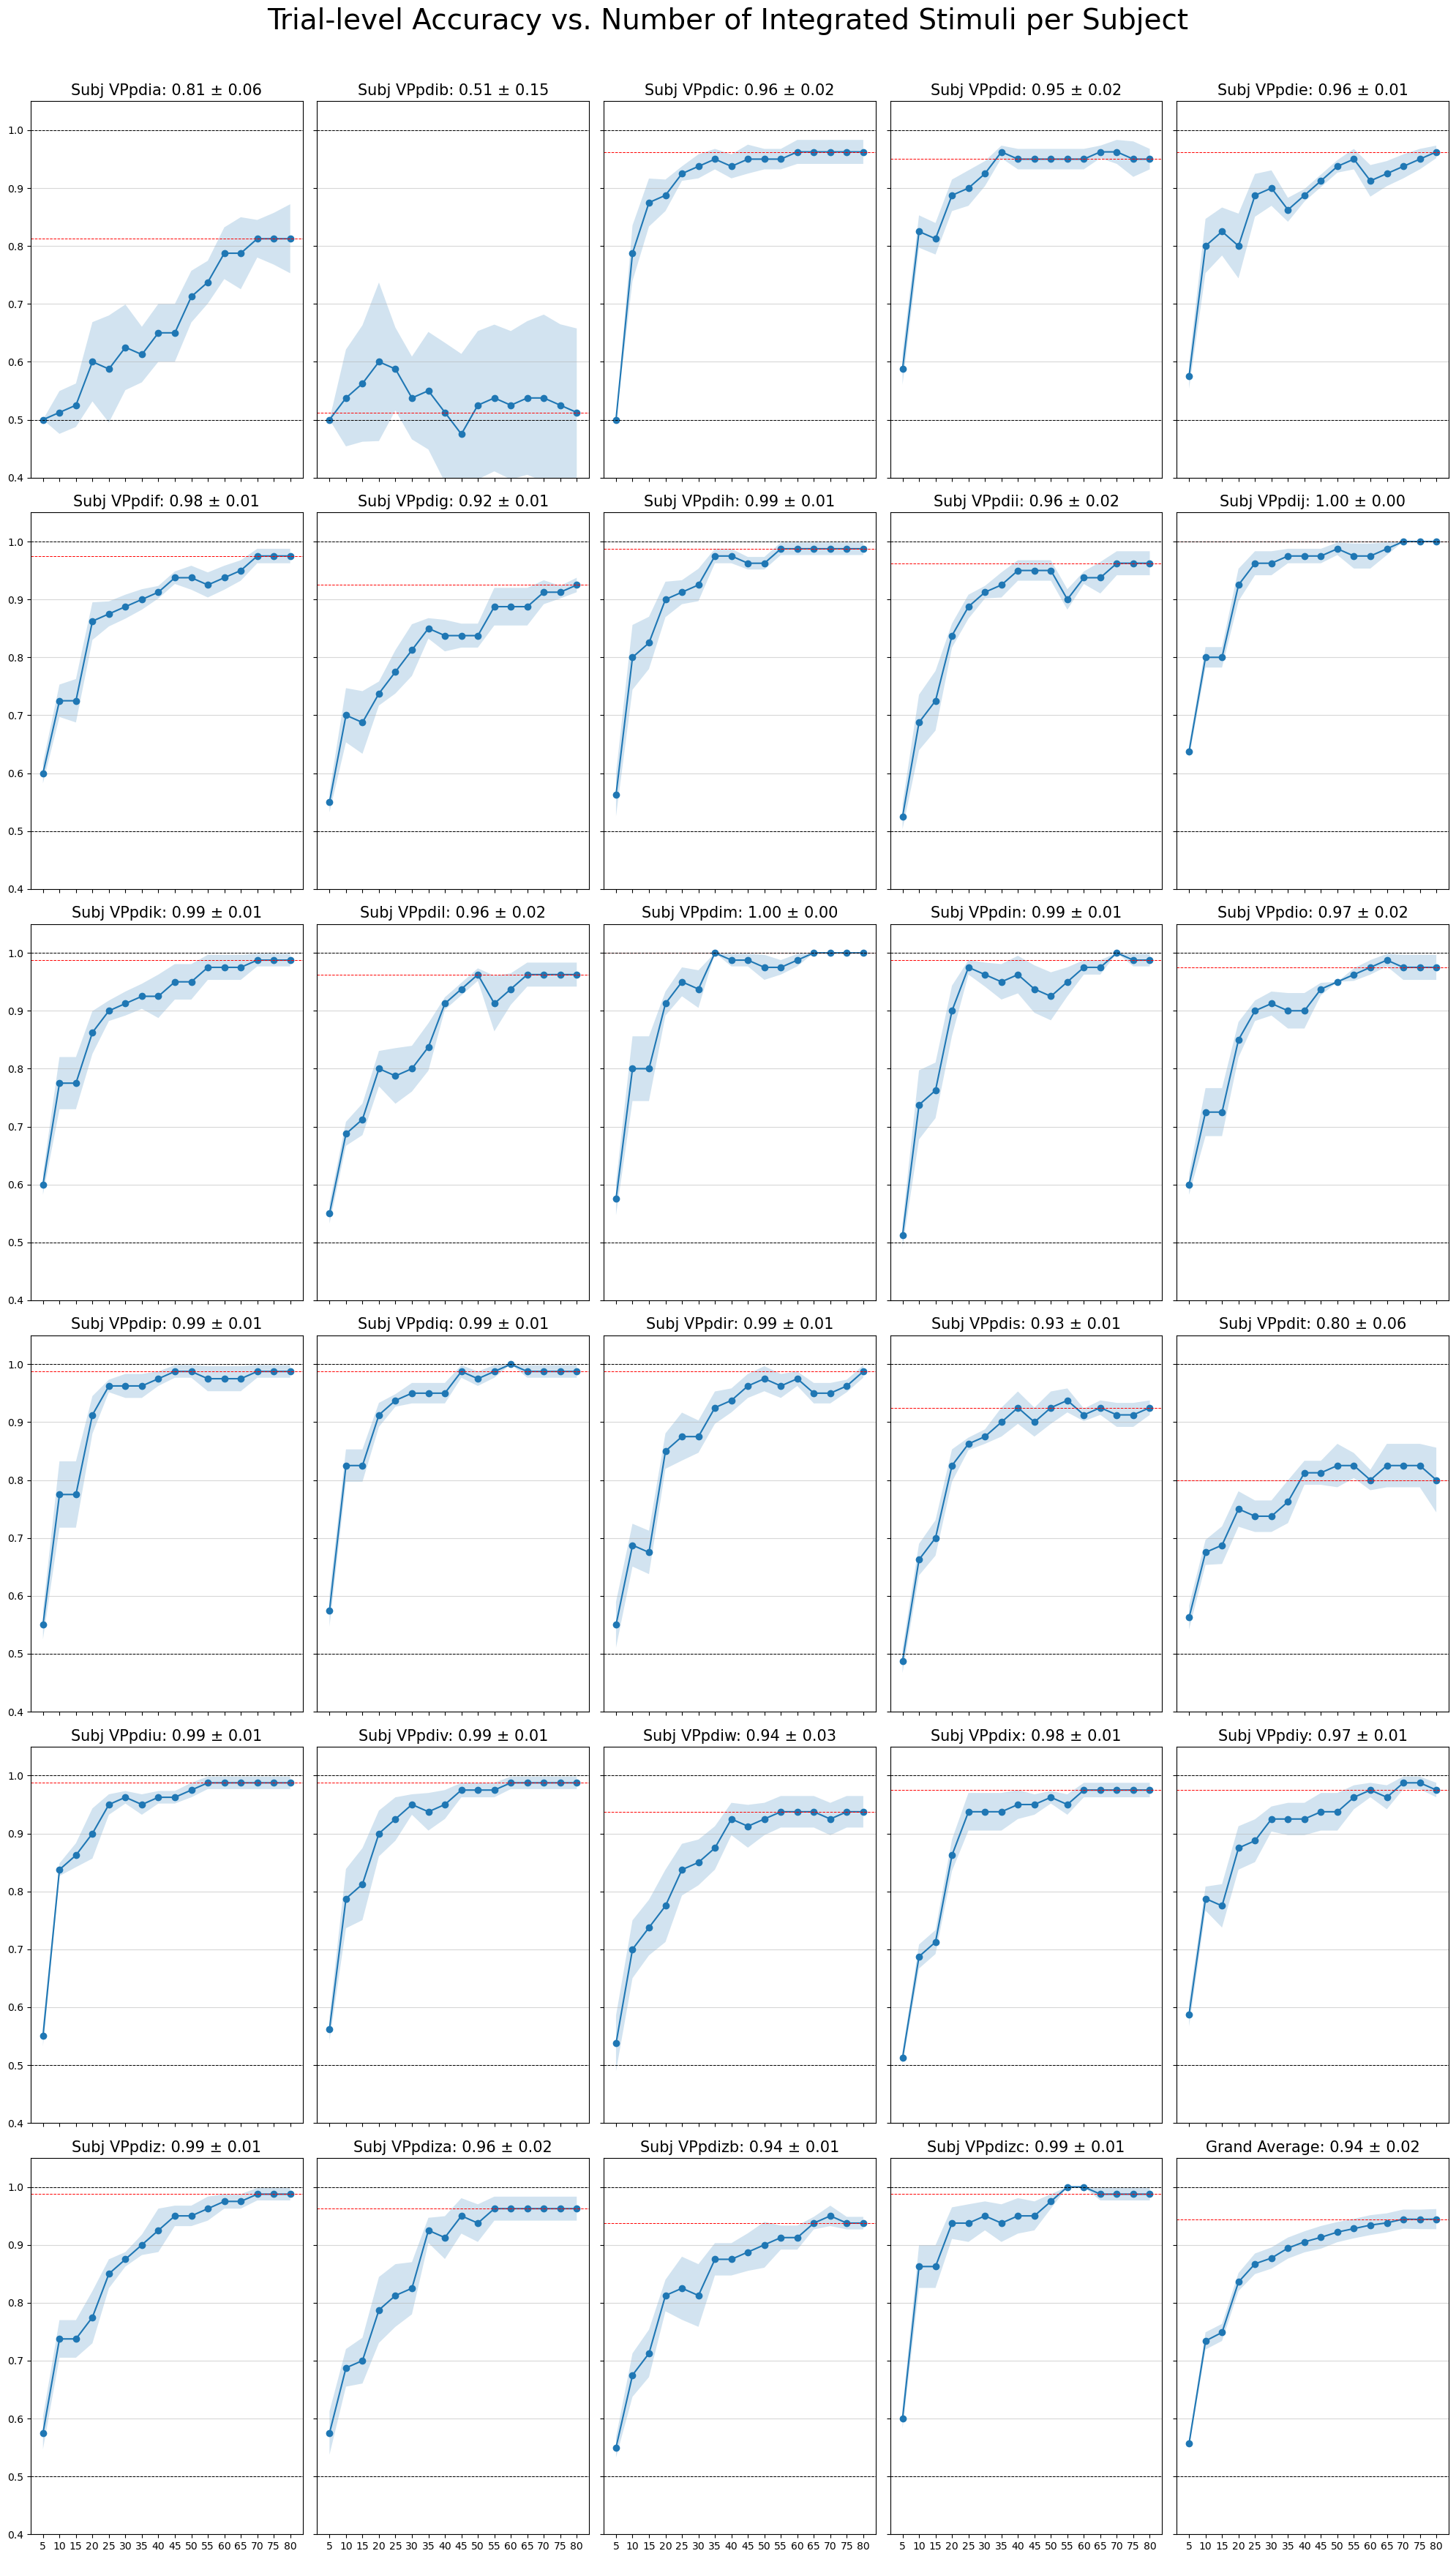

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

subject_ids = list(results_decoding["subjects"].keys())
n_subjects = len(subject_ids)

# Grab the epoch bins from the keys of 'mean_accuracies' (sorted for a nice left-to-right plot)
epoch_bins = sorted(results_decoding["mean_accuracies"].keys())

# Arrange subplots (up to 5 columns, adapt rows accordingly)
n_cols = min(5, n_subjects)
n_rows = (n_subjects + 1 + n_cols - 1) // n_cols

fig, axes = plt.subplots(
    nrows=n_rows, ncols=n_cols,
    figsize=(4 * n_cols, 6 * n_rows),
    sharey=True
)
axes = np.ravel(axes)  # Flatten so we can index them in a 1D fashion

# Plot each subject
for i, subject in enumerate(subject_ids):
    ax = axes[i]
    subject_data = results_decoding["subjects"][subject]
    # subject_data is a dict like:
    #    {fold_idx: {epoch_count -> single_accuracy_float}, ...}

    # We'll collect fold-level accuracies to compute subject-level mean & SE
    subject_mean_accuracies = []
    subject_se_accuracies = []

    # Loop over each epoch_count in ascending order
    for epoch_count in epoch_bins:
        fold_accuracies = []
        for fold_idx, fold_dict in subject_data.items():
            # fold_dict is a dict {epoch_count -> accuracy_float}
            fold_accuracies.append(fold_dict[epoch_count])

        # Now fold_accuracies is a list of that subject’s accuracies for the current epoch_count
        fold_accuracies = np.array(fold_accuracies)
        mean_acc = np.mean(fold_accuracies)
        se_acc = np.std(fold_accuracies) / np.sqrt(len(fold_accuracies))

        subject_mean_accuracies.append(mean_acc)
        subject_se_accuracies.append(se_acc)

    # Convert lists to arrays
    subject_mean_accuracies = np.array(subject_mean_accuracies)
    subject_se_accuracies = np.array(subject_se_accuracies)

    # Compute upper/lower bounds for shading
    lower_bound = subject_mean_accuracies - subject_se_accuracies
    upper_bound = subject_mean_accuracies + subject_se_accuracies

    # Plot
    ax.plot(epoch_bins, subject_mean_accuracies, '-o', label=f"Subject {subject}")
    ax.fill_between(epoch_bins, lower_bound, upper_bound, alpha=0.2)

    ax.set_title(f"Subj {subject}: {subject_mean_accuracies[-1]:.2f} ± {subject_se_accuracies[-1]:.2f}", fontsize=15)
    ax.grid(alpha=0.5, axis='y')
    ax.axhline(y=subject_mean_accuracies[-1], color='red', linestyle='--', linewidth=0.7)
    ax.axhline(y=0.5, color='k', linestyle='--', linewidth=0.7)  # chance line
    ax.axhline(y=1.0, color='k', linestyle='--', linewidth=0.7)
    ax.set_ylim(0.4, 1.05)

    # Fine-tune ticks
    if i % n_cols == 0:
        # Show y-ticks only in the first column
        ax.set_yticks(np.round(np.arange(0.4, 1.05, 0.1), 1))

    # X-ticks only for the last row of subplots
    if i >= (n_rows - 1) * n_cols: 
        ax.set_xticks(epoch_bins)
    else:
        ax.set_xticks(epoch_bins)
        ax.set_xticklabels([])

# 5) Plot "Grand Average" if there's an extra axis left
if n_subjects < len(axes):
    ax_grand = axes[n_subjects]

    grand_mean_accuracies = np.array([
        results_decoding["mean_accuracies"][ec] for ec in epoch_bins
    ])
    grand_se_accuracies = np.array([
        results_decoding["se_accuracies"][ec] for ec in epoch_bins
    ])

    grand_lower_bound = grand_mean_accuracies - grand_se_accuracies
    grand_upper_bound = grand_mean_accuracies + grand_se_accuracies

    ax_grand.plot(epoch_bins, grand_mean_accuracies, '-o', label="Grand Average")
    ax_grand.fill_between(epoch_bins, grand_lower_bound, grand_upper_bound, alpha=0.2)
    ax_grand.set_title(f"Grand Average: {grand_mean_accuracies[-1]:.2f} ± {grand_se_accuracies[-1]:.2f}", fontsize=15)
    ax_grand.grid(alpha=0.5, axis='y')
    ax_grand.axhline(y=0.5, color='k', linestyle='--', linewidth=0.7)
    ax_grand.axhline(y=1.0, color='k', linestyle='--', linewidth=0.7)
    ax_grand.axhline(y=mean_acc_array[-1], color='red', linestyle='--', linewidth=0.7)
    ax_grand.set_ylim(0.4, 1.05)
    ax_grand.set_yticks(np.round(np.arange(0.4, 1.1, 0.1), 1))
    ax_grand.set_xticks(epoch_bins)

# 6) Global figure title and layout
fig.suptitle("Trial-level Accuracy vs. Number of Integrated Stimuli per Subject", 
             y=0.97, fontsize=28)
plt.tight_layout(rect=[0, 0, 1, 0.96])

task = "covert"

save_dir = os.path.join(plots_dir, 'decoding')
os.makedirs(save_dir, exist_ok=True)

plt.savefig(join(save_dir, f"{task}_lda_p300_decC_results_perSubj.png"), dpi=300)
plt.savefig(join(save_dir, f"{task}_lda_p300_decC_results_perSubj.svg"), dpi=300)
plt.plot()
print(f"Plot saved to {save_path}")

## Plot only Grand Average

Accuracy at full epoch integration: 0.94 ± 0.02
Plot saved to C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root\data\analysis\p300\decoding_results\covert_lda_p300_decC_results.npz


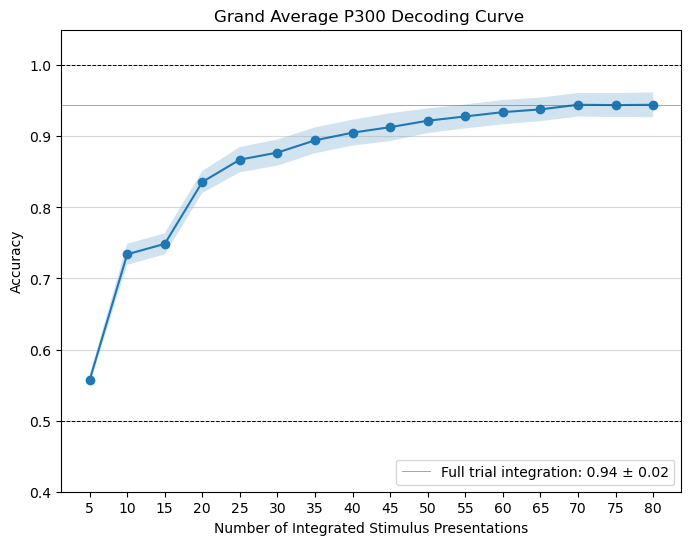

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt


# 1) Extract epoch bins (sorted)
epoch_bins = sorted(results_decoding["mean_accuracies"].keys())

# 2) Build arrays for plotting
mean_acc_array = np.array([results_decoding["mean_accuracies"][eb] for eb in epoch_bins])
se_acc_array   = np.array([results_decoding["se_accuracies"][eb]   for eb in epoch_bins])

# 3) Create a single figure and axis
plt.figure(figsize=(8, 6))

# 4) Plot the mean accuracy
plt.plot(epoch_bins, mean_acc_array, '-o', label='')

# 5) Fill between mean ± SE
lower_bound = mean_acc_array - se_acc_array
upper_bound = mean_acc_array + se_acc_array
plt.fill_between(epoch_bins, lower_bound, upper_bound, alpha=0.2)

# 6) Optional horizontal reference lines
plt.axhline(y=0.5, color='k', linestyle='--', linewidth=0.7)  # chance line
plt.axhline(y=1.0, color='k', linestyle='--', linewidth=0.7)  # perfect accuracy
plt.axhline(y=mean_acc_array[-1], color='red', linestyle='-', linewidth=0.7, alpha = 0.5, label = f'Full trial integration: {mean_acc_array[-1]:.2f} ± {se_acc_array[-1]:.2f}')
# 7) Axis labels, title, and limits
plt.xlabel("Number of Integrated Stimulus Presentations", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.ylim(0.4, 1.05)
plt.xticks(epoch_bins)
plt.title("Grand Average P300 Decoding Curve ", fontsize=12)
plt.grid(alpha=0.5, axis='y')
plt.legend(loc='lower right')

# 8) Save the figure

task = "covert"
save_dir = os.path.join(plots_dir, 'decoding')
os.makedirs(save_dir, exist_ok=True)


plt.savefig(join(save_dir, f"{task}_lda_p300_decC_results_GA.png"), dpi=300)
plt.savefig(join(save_dir, f"{task}_lda_p300_decC_results_GA.svg"), dpi=300)
plt.plot()
print (f"Accuracy at full epoch integration: {mean_acc_array[-1]:.2f} ± {se_acc_array[-1]:.2f}")
print(f"Plot saved to {save_path}")
